In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from IPython.display import display
from matplotlib import ticker
from pathlib import Path
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Reshape, Input, Dense, Flatten, Conv2D, Dropout
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D, concatenate, BatchNormalization

### Константы для путей к файлам

In [2]:
# Пути к обработанным данным
# Путь к X части выборки с массивами в каждой ячейке
path_to_array_like_X_data = 'data\\Prepared data\\Run1\\X_data_array_like.xlsx' 
# Путь к X части выборки, с данными представленными с помощью иерархиеских индексов
path_to_hierarhical_X_data = 'data\\Prepared data\\Run1\\X_data_hierarhical.xlsx' 
# Путь к Y части выборки
path_to_Y_data = 'data\\Prepared data\\Run1\\Y_data(binary_classification).xlsx' 


### Константы для обработки данных

In [3]:
PREP_image_size = 10

In [4]:
# детерминация случайных величин, отвечающих за выбор первоначальных весов и биасов
tf.compat.v1.set_random_seed(290)
tf.random.set_seed(290)

In [5]:
def to_list_of_64_values(x):
  # делим начальную строку на пары чисел
  # пары чисел тут - это просто строки
  x = str(x[1:-1]).split(',')
  x = np.array(x)

  x = x.astype(float)
  
  return x

In [6]:
# прочесть файл X_data_array-like.xlsx
def get_array_like_X_df(path: str):
    df = pd.read_excel(path,index_col=[0])
    df = df.apply(lambda x: 
                  x.apply(to_list_of_64_values, convert_dtype=True))
    return df

In [7]:
# прочесть файл X_data_hierarhical.xlsx 
def get_hierarhical_X_df(path: str):
    df = pd.read_excel(path,index_col=[0,1])
    return df

In [8]:
# прочесть файл Y_data(binary_classification).xlsx
def get_Y_df(path: str):
    df = pd.read_excel(path,index_col=[0])
    return df

In [9]:
# приведение к виду, который принимают на вход слои Conv2D
# (batch, channels, rows, cols) если data_format='channels_first'
# (batch, rows, cols, channels) если data_format='channels_last'
# тут выбран последний формат 
# а так как "изображения" состоят из 64 измерений, то 
# каналов либо 64, либо по 32
def reshape_orig_X_df_to_image_like_numpy(df, image_size):
    rows_count = df.shape[0] - df.shape[0] % image_size
    cols_count = df.shape[1] - df.shape[1] % image_size
    set_len = 64

    images_list = list()
    print('Orig df shape: ', df.shape)

    for i in range(0,rows_count,image_size):
        for j in range(0,cols_count,image_size):
            temp = np.zeros((image_size,image_size,set_len), dtype='float32')
            num = df.iloc[i:i+image_size,j:j+image_size].to_numpy()
            
            for i2 in range(image_size):
                for j2 in range(image_size):
                    temp[i2,j2] = num[i2,j2]

            images_list.append(temp)

    images_arr = np.array(images_list)        

    print('Result numpy array shape: ', images_arr.shape)
    
    return images_arr

In [10]:
def reshape_orig_Y_df_to_image_like_numpy(df, image_size)   : 
    rows_count = df.shape[0] - df.shape[0] % image_size
    cols_count = df.shape[1] - df.shape[1] % image_size

    results_list = list()
    print('Orig df shape: ', df.shape)

    for i in range(0,rows_count,image_size):
        for j in range(0,cols_count,image_size):

            num = df.iloc[i:i+image_size,j:j+image_size].to_numpy().astype('float32')  
            results_list.append(num)

    results_arr = np.array(results_list)        

    print('Result numpy array shape: ', results_arr.shape)  
    
    return results_arr

In [11]:
# чтение X данных
arr_X_df = get_array_like_X_df(path_to_array_like_X_data)
display(arr_X_df)

,detector_0,detector_1,detector_2,detector_3,detector_4,detector_5,detector_6,detector_7,detector_8,detector_9,...,detector_390,detector_391,detector_392,detector_393,detector_394,detector_395,detector_396,detector_397,detector_398,detector_399
row,,,,,,,,,,,,,,,,,,,,,
0,"[25.8, 26.1, 26.2, 26.3, 26.5, 26.6, 27.1, 29....","[25.6, 25.8, 25.9, 26.1, 26.2, 26.3, 26.6, 26....","[25.3, 25.5, 25.7, 25.8, 26.0, 26.1, 26.2, 28....","[25.6, 25.8, 25.9, 26.1, 26.2, 26.3, 26.4, 26....","[25.9, 26.2, 26.3, 26.5, 26.6, 26.8, 26.9, 27....","[25.8, 26.1, 26.2, 26.3, 26.4, 26.6, 26.7, 26....","[25.5, 25.7, 25.8, 25.9, 26.1, 26.3, 26.4, 28....","[25.5, 25.7, 25.7, 25.9, 26.0, 26.1, 26.2, 26....","[25.6, 25.9, 26.0, 26.1, 26.3, 26.4, 26.5, 28....","[25.6, 25.9, 26.0, 26.1, 26.2, 26.4, 26.5, 26....",...,"[25.5, 25.7, 25.8, 25.9, 26.1, 26.2, 26.3, 26....","[25.9, 26.1, 26.2, 26.4, 26.5, 26.6, 26.7, 26....","[25.8, 25.9, 26.1, 26.3, 26.4, 26.6, 26.8, 26....","[25.6, 25.8, 25.9, 26.1, 26.3, 26.5, 26.6, 26....","[25.6, 25.7, 25.9, 26.0, 26.1, 26.3, 26.4, 26....","[25.6, 25.8, 26.0, 26.1, 26.2, 26.4, 26.5, 26....","[25.5, 25.6, 25.8, 25.9, 26.0, 26.1, 26.3, 26....","[25.3, 25.5, 25.6, 25.7, 25.9, 26.0, 26.3, 28....","[25.1, 25.2, 25.3, 25.5, 25.6, 25.7, 25.9, 26....","[25.1, 25.4, 25.5, 25.7, 25.8, 26.0, 26.1, 28...."
1,"[25.8, 26.0, 26.1, 26.3, 26.4, 26.6, 26.7, 29....","[25.6, 25.9, 26.0, 26.1, 26.2, 26.4, 26.7, 28....","[25.3, 25.5, 25.7, 25.8, 26.0, 26.1, 26.2, 28....","[25.6, 25.8, 25.9, 25.9, 26.1, 26.2, 26.3, 26....","[25.9, 26.2, 26.3, 26.5, 26.6, 26.8, 26.9, 27....","[25.6, 25.8, 25.9, 26.0, 26.1, 26.3, 26.5, 26....","[25.5, 25.7, 25.8, 25.9, 26.1, 26.3, 26.4, 26....","[25.8, 25.9, 25.9, 26.0, 26.1, 26.3, 26.5, 26....","[25.6, 25.9, 26.0, 26.1, 26.3, 26.5, 26.6, 26....","[25.5, 25.7, 25.9, 26.0, 26.1, 26.3, 26.5, 28....",...,"[25.5, 25.7, 25.8, 25.9, 26.1, 26.2, 26.3, 26....","[25.9, 26.1, 26.3, 26.4, 26.5, 26.6, 26.7, 26....","[25.8, 26.0, 26.2, 26.3, 26.4, 26.6, 26.7, 26....","[24.7, 25.7, 25.8, 26.0, 26.1, 26.3, 26.5, 26....","[25.5, 25.7, 25.8, 25.9, 26.1, 26.2, 26.3, 26....","[25.6, 25.8, 26.0, 26.1, 26.2, 26.4, 26.6, 26....","[25.3, 25.4, 25.7, 25.8, 25.9, 26.1, 26.2, 26....","[25.3, 25.5, 25.7, 25.8, 25.9, 26.1, 26.3, 28....","[25.0, 25.1, 25.3, 25.5, 25.6, 25.7, 25.8, 26....","[25.0, 25.3, 25.4, 25.5, 25.7, 25.8, 26.1, 28...."
2,"[25.6, 25.8, 25.9, 26.1, 26.2, 26.3, 26.5, 28....","[25.5, 25.7, 25.8, 25.9, 26.1, 26.3, 26.4, 28....","[25.5, 25.7, 25.8, 25.9, 26.0, 26.2, 26.3, 28....","[25.6, 25.7, 25.9, 26.0, 26.1, 26.3, 26.4, 26....","[25.8, 26.1, 26.2, 26.3, 26.5, 26.6, 26.7, 26....","[25.6, 25.9, 26.0, 26.1, 26.3, 26.4, 26.5, 26....","[25.5, 25.7, 25.8, 25.9, 26.1, 26.3, 26.4, 26....","[25.9, 26.1, 26.2, 26.3, 26.5, 26.6, 26.7, 26....","[25.6, 25.9, 26.0, 26.1, 26.3, 26.4, 26.5, 28....","[25.5, 25.7, 25.8, 25.9, 26.1, 26.3, 26.4, 28....",...,"[25.5, 25.7, 25.8, 25.9, 26.0, 26.1, 26.2, 26....","[25.9, 26.1, 26.3, 26.4, 26.5, 26.6, 26.8, 26....","[25.8, 25.9, 26.0, 26.1, 26.3, 26.4, 26.7, 26....","[24.7, 24.8, 25.7, 25.9, 26.0, 26.1, 26.3, 26....","[25.5, 25.6, 25.8, 25.9, 26.1, 26.2, 26.3, 26....","[25.6, 25.8, 26.0, 26.1, 26.3, 26.4, 26.5, 26....","[25.3, 25.4, 25.7, 25.8, 25.9, 26.0, 26.1, 26....","[25.1, 25.3, 25.5, 25.6, 25.7, 25.8, 26.0, 26....","[25.3, 25.5, 25.6, 25.7, 25.9, 26.0, 26.3, 28....","[25.0, 25.1, 25.3, 25.4, 25.5, 25.7, 25.8, 26...."
3,"[25.5, 25.8, 25.9, 26.0, 26.1, 26.3, 26.5, 28....","[25.5, 25.7, 25.8, 25.9, 26.1, 26.2, 26.3, 28....","[25.3, 25.5, 25.7, 25.8, 25.9, 26.1, 26.2, 26....","[25.8, 25.9, 26.1, 26.2, 26.3, 26.5, 26.6, 26....","[25.8, 25.9, 26.1, 26.2, 26.3, 26.5, 26.6, 26....","[25.6, 25.9, 26.0, 26.1, 26.2, 26.4, 26.5, 26....","[25.5, 25.7, 25.8, 25.9, 26.1, 26.3, 26.4, 26....","[26.1, 26.2, 26.3, 26.5, 26.6, 26.7, 26.9, 27....","[25.6, 25.9, 26.0, 26.1, 26.3, 26.4, 26.5, 26....","[25.5, 25.7, 25.8, 25.9, 26.1, 26.3, 26.4, 28....",...,"[25.5, 25.7, 25.8, 25.9, 26.0, 26.2, 26.3, 26....","[26.1, 26.3, 

In [12]:
# чтение Y данных
Y_df = get_Y_df(path_to_Y_data)
display(Y_df)

,detector_0,detector_1,detector_2,detector_3,detector_4,detector_5,detector_6,detector_7,detector_8,detector_9,...,detector_390,detector_391,detector_392,detector_393,detector_394,detector_395,detector_396,detector_397,detector_398,detector_399
Row,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
111,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
112,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#  Подготовка X части выборки

In [13]:
# представим данные в image-like numpy формате
images_arr = reshape_orig_X_df_to_image_like_numpy(arr_X_df, PREP_image_size)

# поделим x выборку на значения времен и амплитуд
X_time = images_arr[:,:,:,:32]
X_amp = images_arr[:,:,:,32:]

Orig df shape:  (115, 400)
Result numpy array shape:  (440, 10, 10, 64)


In [14]:
# стандартизуем данные
X_time_max = X_time.max()
X_amp_max = X_amp.max()

print(f'X_time_max: {X_time_max}')
print(f'X_amp_max: {X_amp_max}')

X_time = X_time / X_time_max
X_amp = X_amp / X_amp_max

X_time_max: 44.5
X_amp_max: 62.992000579833984


# Подготовка Y части выборки

In [15]:
Y_res = reshape_orig_Y_df_to_image_like_numpy(Y_df, PREP_image_size)  

Orig df shape:  (115, 400)
Result numpy array shape:  (440, 10, 10)


In [16]:
print(X_time.shape)
print(X_amp.shape)
print(Y_res.shape)

(440, 10, 10, 32)
(440, 10, 10, 32)
(440, 10, 10)


In [17]:
# Найдем на каких картинках есть дефекты
defects_nums = list()
for i in range(Y_res.shape[0]):
    if np.sum(Y_res[i] > 0) >= 1:
        defects_nums.append(True)
    else:
        defects_nums.append(False)

defects_nums = np.array(defects_nums, dtype='bool')
        
print(f'Для карт высотой и шириной в {PREP_image_size} и общим кличеством: {Y_res.shape[0]} \
        дефекты присутствуеют на {np.sum(defects_nums)} картах')        


Для карт высотой и шириной в 10 и общим кличеством: 440         дефекты присутствуеют на 33 картах


In [18]:
# Выделим из выборок все карты с дефектами
X_time_def = X_time[defects_nums]
X_time_non_def = X_time[~defects_nums]

print('X_time')
print(X_time_def.shape, X_time_non_def.shape)

Y_res_def = Y_res[defects_nums]
Y_res_non_def = Y_res[~defects_nums]

print('Y_res')
print(Y_res_def.shape, Y_res_non_def.shape)

X_amp_def = X_amp[defects_nums]
X_amp_non_def = X_amp[~defects_nums]

print('X_amp')
print(X_amp_def.shape, X_amp_non_def.shape)                      

X_time
(33, 10, 10, 32) (407, 10, 10, 32)
Y_res
(33, 10, 10) (407, 10, 10)
X_amp
(33, 10, 10, 32) (407, 10, 10, 32)


In [19]:
# увеличим кол-во данных за счет повората матриц на 90 градусов
# повернутое изображение = другое изображение

X_time_def = np.concatenate([X_time_def,
                            np.rot90(X_time_def,1,[1,2]),
                            np.rot90(X_time_def,2,[1,2]),
                            np.rot90(X_time_def,3,[1,2])],axis=0)

X_amp_def = np.concatenate([X_amp_def,
                            np.rot90(X_amp_def,1,[1,2]),
                            np.rot90(X_amp_def,2,[1,2]),
                            np.rot90(X_amp_def,3,[1,2])],axis=0)

Y_res_def = np.concatenate([Y_res_def,
                            np.rot90(Y_res_def,1,[1,2]),
                            np.rot90(Y_res_def,2,[1,2]),
                            np.rot90(Y_res_def,3,[1,2])],axis=0)

print('Result')
print(X_time_def.shape)
print(X_amp_def.shape)
print(Y_res_def.shape)

Result
(132, 10, 10, 32)
(132, 10, 10, 32)
(132, 10, 10)


In [20]:
# Разбавим данные с дефектами данными без дефектов

X_time_train = np.append(X_time_def, X_time_non_def[:int(np.sum(defects_nums)/2)],axis=0)
X_amp_train = np.append(X_amp_def, X_amp_non_def[:int(np.sum(defects_nums)/2)],axis=0)
Y_res_train = np.append(Y_res_def, Y_res_non_def[:int(np.sum(defects_nums)/2)],axis=0)

print('Result')
print(X_time_train.shape)
print(X_amp_train.shape)
print(Y_res_train.shape)

Result
(148, 10, 10, 32)
(148, 10, 10, 32)
(148, 10, 10)


In [ ]:
x = np.arange(32)
x = np.reshape(x,(2,2,2,4))
print(x[0,0])
print(x[0,1])
print(';;;;;;;;;;;;;;;;;;;;;;;;')
x_re = np.rot90(x,1,[1,2])
print(x_re[0,0])
print(x_re[0,1])
print(';;;;;;;;;;;;;;;;;;;;;;;;')
x = np.concatenate([x,x_re],axis=0)
print(x.shape)

In [82]:
x = np.arange(10)
print(x)
print(x[[1,4,5]])
print(x[[False,True,False,True,False,True,False,True,False,True]])

[0 1 2 3 4 5 6 7 8 9]
[1 4 5]
[1 3 5 7 9]


# Тренировка модели

In [2]:
# всякие константы для последующей работы

#///////////////////////////////// для компиляции 

CMP_learning_rate = 0.08 #0.04 # шаг сходимости back propogation
#CMP_solver = keras.optimizers.Adam(CMP_learning_rate) # оптимизатор
CMP_solver = keras.optimizers.SGD(CMP_learning_rate) # оптимизатор
CMP_loss_func = 'binary_crossentropy'#'mean_squared_error'# функция потерь
#///////////////////////////////// для колбэков

    # для Early_stopping
ES_patience = 15 # кол-во эпох без улучшений
ES_min_delta = 0.00005 # минимальное улучшение параметра за cur_patience
ES_monitor_parametr =  'loss' # отслеживаемый параметр 
ES_save_best_weights = True # сохранять ли веса нейронки с лучшими результатами
    
    # для ReduceLROnPlateau
RLPOP_monitor_parametr = 'val_loss'  # отслеживаемый параметр 
RLPOP_factor = 0.4 # множитель для расчета нового шага сходимости (new_learning_rate = old_learning_rate*RLPOP_factor)
RLPOP_patience = 10 # кол-во эпох без улучшений
RLPOP_verbose = 1 # выводить ли прогресс изменения шага сходимости в его процессее
RLPOP_mode = 'auto' # выбирает, уменьшать шаг сходимости при росте величины или при её уменьшении
RLPOP_min_delta = 0.0001 # порог изменения отслеживаемого значения
RLPOP_cooldown = 0 # количество эпох до возобновления работы после изменения шага сходимости
RLPOP_min_lr = 0 # минимальное значение шага сходимости

    # для CallbackList
CBL_add_history = True # вызывать ли колбэк History (если он не был довавлен вручную)
CBL_add_progbar = True # вызывать ли колбэк ProgbarLogger (если он не был довавлен вручную)
    
#///////////////////////////////// для тренировки

FIT_batch_size = 2 # размер bach при обучении/тестировании1
FIT_shuffle = True # перемешивать ли данные
FIT_verbose = True # выводить ли прогресс обучения в его процессее
FIT_epochs = 60 # количество эпох обучения
FIT_validation_split = 0.10 #0.20 # процент валидационных данных, отсекаемых из тестовой выборки

In [3]:
input_time = Input((10,10,32))
t = Conv2D(128, (2,2), padding='same', activation='relu', input_shape=(28,28,1))(input_time)
t = Conv2D(128, (2,2), padding='same', activation='relu')(t)
t = MaxPooling2D((2,2), strides=2)(t)
t = Conv2D(512, (2,2), padding='same', activation='relu')(t)
t = Conv2D(512, (2,2), padding='same', activation='relu')(t)
t = BatchNormalization()(t)
output_time = Flatten()(t)

input_amp = Input((10,10,32))
a = Conv2D(128, (2,2), padding='same', activation='linear', input_shape=(28,28,1))(input_amp)
a = Conv2D(128, (2,2), padding='same', activation='linear')(a)
a = MaxPooling2D((2,2), strides=2)(a)
a = Conv2D(512, (2,2), padding='same', activation='linear')(a)
a = Conv2D(512, (2,2), padding='same', activation='linear')(a)
a = BatchNormalization()(a)
output_amp = Flatten()(a)

at = concatenate([output_time,output_amp])
at = Reshape((8,8,400))(at)
at = Conv2D(200, (2,2), padding='same', activation='linear')(at)
at = Conv2D(200, (2,2), padding='same', activation='linear')(at)
at = MaxPooling2D((2,2), strides=2)(at)
at = Conv2D(100, (2,2), padding='same', activation='linear')(at)
at = Conv2D(100, (2,2), padding='same', activation='linear')(at)
at = MaxPooling2D((2,2), strides=2)(at)
at = Conv2D(50, (2,2), padding='same', activation='relu')(at)
at = Conv2D(25, (2,2), padding='same', activation='sigmoid')(at)


output = Reshape((10,10,1))(at)

model = keras.Model([input_time,input_amp], output, name='model')
model.compile(optimizer=CMP_solver, loss=CMP_loss_func)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 10, 32)  0           []                               
                                ]                                                                 
                                                                                                  
 input_2 (InputLayer)           [(None, 10, 10, 32)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 10, 10, 128)  16512       ['input_1[0][0]']                
                                                                                              

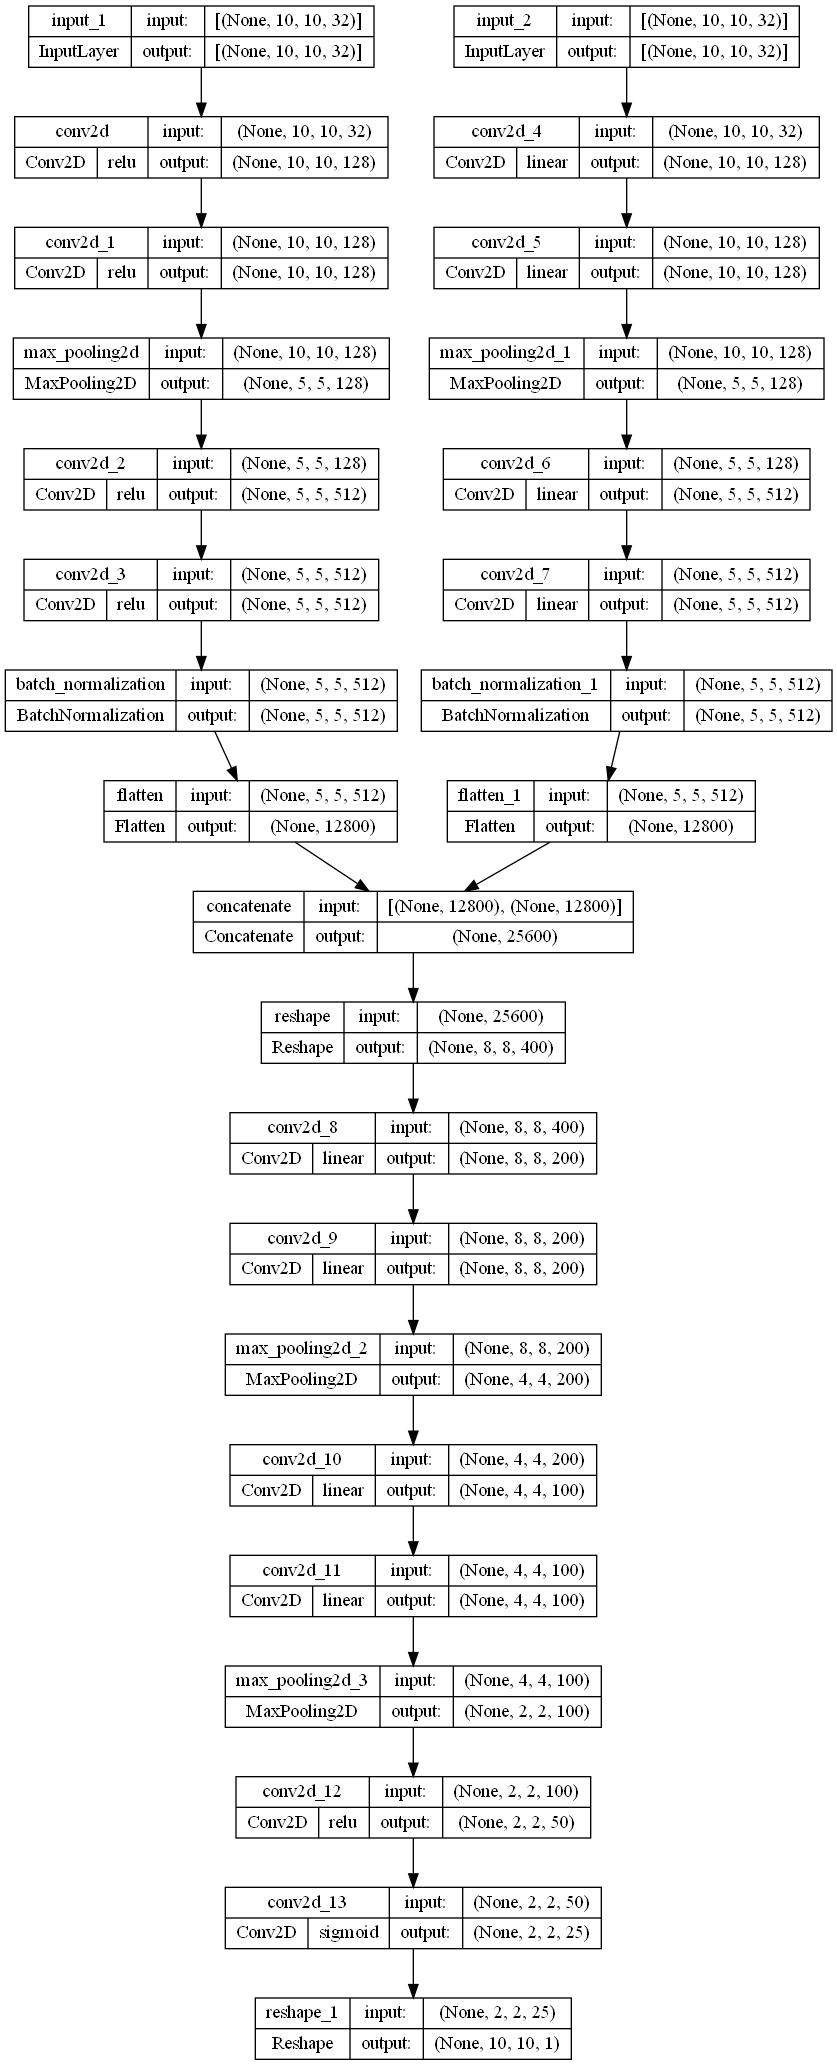

In [4]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [32]:
# Создание и настройка колбэков
callback_list = [] # массив колбэков до подачи в колбек "callbacklist"

temp = keras.callbacks.EarlyStopping(
            monitor = ES_monitor_parametr, 
            min_delta = ES_min_delta, 
            patience = ES_patience,
            restore_best_weights = ES_save_best_weights
            )
callback_list.append(temp)

temp = keras.callbacks.ReduceLROnPlateau(
            monitor = RLPOP_monitor_parametr, 
            factor = RLPOP_factor, 
            patience = RLPOP_patience, 
            verbose = RLPOP_verbose,
            mode = RLPOP_mode, 
            min_delta = RLPOP_min_delta, 
            cooldown = RLPOP_cooldown, 
            min_lr = RLPOP_min_lr
            )
callback_list.append(temp)

FIT_callback_list = keras.callbacks.CallbackList(
            callbacks = callback_list, 
            add_history = CBL_add_history, 
            add_progbar = CBL_add_progbar, 
            model = model
            )

In [33]:
history = model.fit([X_time_train,X_amp_train],
                    Y_res_train,
                    batch_size = FIT_batch_size, 
                    epochs = FIT_epochs, 
                    verbose = FIT_verbose, 
                    validation_split = FIT_validation_split, 
                    shuffle = FIT_shuffle, 
                    callbacks = FIT_callback_list)

67/67 [==============================] - ETA: 0s - loss: 0.0051
Epoch 00035: ReduceLROnPlateau reducing learning rate to 0.031999999284744264.
67/67 [==============================] - ETA: 0s - loss: 0.0027- ETA: 0s - loss: 0.00
Epoch 00045: ReduceLROnPlateau reducing learning rate to 0.012799999117851258.
67/67 [==============================] - ETA: 0s - loss: 0.0023
Epoch 00055: ReduceLROnPlateau reducing learning rate to 0.0051199994981288915.
67/67 [==============================] - 6s 91ms/step - loss: 0.0022 - val_loss: 0.0094


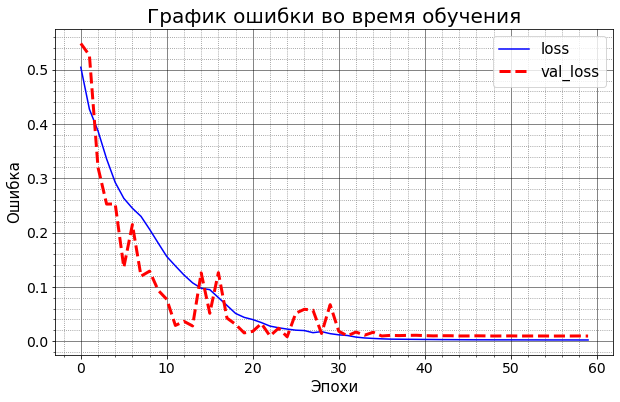

In [34]:
# Вывод графика изменения ошибки

fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(6)

plt.plot(history.history['loss'], label='loss',  linewidth=1.5, color='blue')
plt.plot(history.history['val_loss'], linestyle = '--', label='val_loss',  linewidth=3, color='red')

ax.set_title('График ошибки во время обучения', fontsize=20)
ax.set_ylabel('Ошибка', fontsize=15)
ax.set_xlabel('Эпохи', fontsize=15)

#  Устанавливаем интервал основных делений:
#ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
#ax.yaxis.set_major_locator(ticker.MultipleLocator(5))

#  Устанавливаем форматирование чисел основных делений:
#ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.d'))
#ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.d'))

#  Устанавливаем форматирование делений:
ax.xaxis.set_tick_params(which = 'major', labelsize = 14)
ax.yaxis.set_tick_params(which = 'major', labelsize = 14)

ax.minorticks_on()
ax.grid(which='major', color = 'k', alpha = 0.6)
ax.grid(which='minor', color = 'gray', linestyle = ':')

ax.legend(fontsize = 15, facecolor = "white", loc = 'upper right')

plt.show()

In [35]:
model.save("Networks//CNN//NetWork_(10x32+10x32)_to(10x1)_0_0022")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: NetWork_(10x32+10x32)_to(10x1)_0_0022\assets


In [36]:
# тест модели
model.evaluate([X_time,X_amp], Y_res, batch_size = FIT_batch_size)

220/220 [==============================] - 5s 22ms/step - loss: 0.0130


0.013002987019717693

In [38]:
res = model.predict([X_time_def,X_amp_def])
res.shape

(132, 10, 10, 1)

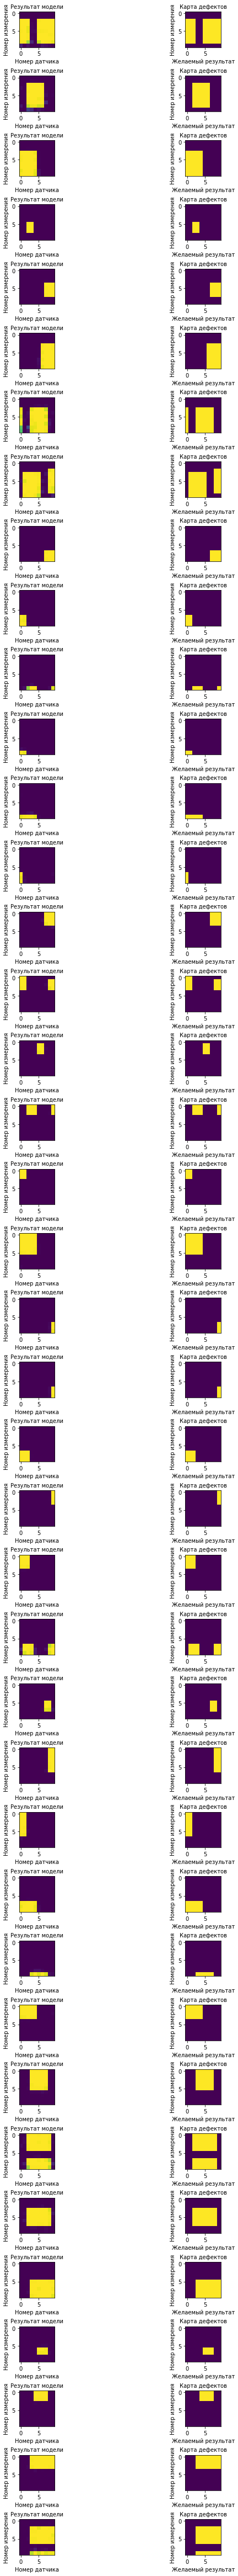

In [39]:
fig, ax = plt.subplots(40,2)

fig.set_figwidth(10)
fig.set_figheight(80)

for i,iax in zip(range(40),ax):
    
    iax[0].imshow(res[i])

    iax[0].set_xlabel('Номер датчика', fontsize=10) 
    iax[0].set_ylabel('Номер измерения', fontsize=10) 
    iax[0].set_title('Результат модели', fontsize=10) 

    iax[1].imshow(Y_res_def[i])

    iax[1].set_xlabel('Желаемый результат', fontsize=10) 
    iax[1].set_ylabel('Номер измерения', fontsize=10) 
    iax[1].set_title('Карта дефектов', fontsize=10) 

     
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.8)
plt.show()

In [ ]:
'''input_time = Input((5,5,32))

t = Conv2D(128, (3,3), padding='same', activation='relu', input_shape=(28,28,1))(input_time)
t = Conv2D(128, (3,3), padding='same', activation='relu')(t)
t = MaxPooling2D((5,5), strides=2)(t)
t = Conv2D(256, (3,3), padding='same', activation='relu')(t)
t = Conv2D(256, (3,3), padding='same', activation='relu')(t)
t = UpSampling2D((5,5))(t)
t = Conv2D(128, (3,3), padding='same', activation='relu')(t)
t = Conv2D(128, (3,3), padding='same', activation='relu')(t)
t = Conv2D(64, (3,3), padding='same', activation='relu')(t)
t = Conv2D(32, (3,3), padding='same', activation='relu')(t)
output = Conv2D(1, (3,3), padding='same', activation='relu')(t)

model = keras.Model(input_time, output, name='model')
model.compile(optimizer=CMP_solver, loss=CMP_loss_func)
print(model.summary())'''
#input_amp = Input((5,5,32))

In [ ]:
'''input_img = Input((5,5,32))

x = Flatten()(input_img)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
encoded = Dense(64, activation='relu')(x)

d = Dense(64, activation='relu')(encoded)
d = Dense(5*5, activation='sigmoid')(d)
decoded = Reshape((5,5,1))(d)

autoencoder = keras.Model(input_img, decoded, name='autoencoder')
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

print(autoencoder.summary())'''

In [77]:
arrays = np.array([np.arange(i,i+2) for i in range(0,24,2)])

print('Init Array |||||||||||||||||||')
print(arrays.shape)

x = np.reshape(arrays,(4,3,2,1))
#x = np.reshape(arrays,(5,4,2))

print('Array ||||||||||||||||||||||||')
print(x.shape)
print(x,'\n')

print('Masks ||||||||||||||||||||||||')
print(x.shape)
print(f'Mask 1:\n',np.sum(x>10,axis=0))
print(f'Mask 2:\n',np.sum(x>10,axis=1))
print(f'Mask 3:\n',np.sum(x>10,axis=2))
print(f'Mask 4:\n',np.sum(x>10,axis=3))

Init Array |||||||||||||||||||
(12, 2)
Array ||||||||||||||||||||||||
(4, 3, 2, 1)
[[[[ 0]
   [ 1]]

  [[ 2]
   [ 3]]

  [[ 4]
   [ 5]]]


 [[[ 6]
   [ 7]]

  [[ 8]
   [ 9]]

  [[10]
   [11]]]


 [[[12]
   [13]]

  [[14]
   [15]]

  [[16]
   [17]]]


 [[[18]
   [19]]

  [[20]
   [21]]

  [[22]
   [23]]]] 

Masks ||||||||||||||||||||||||
(4, 3, 2, 1)
Mask 1:
 [[[2]
  [2]]

 [[2]
  [2]]

 [[2]
  [3]]]
Mask 2:
 [[[0]
  [0]]

 [[0]
  [1]]

 [[3]
  [3]]

 [[3]
  [3]]]
Mask 3:
 [[[0]
  [0]
  [0]]

 [[0]
  [0]
  [1]]

 [[2]
  [2]
  [2]]

 [[2]
  [2]
  [2]]]
Mask 4:
 [[[0 0]
  [0 0]
  [0 0]]

 [[0 0]
  [0 0]
  [0 1]]

 [[1 1]
  [1 1]
  [1 1]]

 [[1 1]
  [1 1]
  [1 1]]]


In [ ]:
input_time = Input((4,4,32))
t = Conv2D(128, (2,2), padding='same', activation='relu', input_shape=(28,28,1))(input_time)
t = Conv2D(128, (2,2), padding='same', activation='relu')(t)
t = MaxPooling2D((2,2), strides=2)(t)
t = Conv2D(512, (2,2), padding='same', activation='relu')(t)
t = Conv2D(512, (2,2), padding='same', activation='relu')(t)
#t = UpSampling2D((2,2))(t)
#t = Conv2D(256, (3,3), padding='same', activation='linear')(t)
#t = MaxPooling2D((2,2), strides=2)(t)
#t = Conv2D(256, (3,3), padding='same', activation='relu')(t)
#t = MaxPooling2D((2,2), strides=2)(t)
output_time = Flatten()(t)

input_amp = Input((4,4,32))
a = Conv2D(128, (2,2), padding='same', activation='linear', input_shape=(28,28,1))(input_amp)
a = Conv2D(128, (2,2), padding='same', activation='linear')(a)
a = MaxPooling2D((2,2), strides=2)(a)
a = Conv2D(512, (2,2), padding='same', activation='linear')(a)
a = Conv2D(512, (2,2), padding='same', activation='linear')(a)
#a = UpSampling2D((2,2))(a)
#a = Conv2D(256, (3,3), padding='same', activation='linear')(a)
#a = MaxPooling2D((2,2), strides=2)(a)
#a = Conv2D(256, (3,3), padding='same', activation='linear')(a)
#a = MaxPooling2D((2,2), strides=2)(a)
output_amp = Flatten()(a)

at = concatenate([output_time,output_amp])
at = Reshape((4,4,256))(at)
at = Conv2D(128, (2,2), padding='same', activation='linear')(at)
at = Conv2D(128, (2,2), padding='same', activation='linear')(at)
at = MaxPooling2D((2,2), strides=2)(at)
at = Conv2D(64, (2,2), padding='same', activation='linear')(at)
at = Conv2D(64, (2,2), padding='same', activation='linear')(at)
at = MaxPooling2D((2,2), strides=2)(at)
at = Conv2D(32, (2,2), padding='same', activation='relu')(at)
at = Conv2D(16, (2,2), padding='same', activation='relu')(at)
#at = Dropout(rate=0.2)(at)
'''at = Dense(2048, activation='linear')(at)
at = Dense(1024, activation='linear')(at)
at = Dense(512, activation='linear')(at)
at = Dense(256, activation='linear')(at)
at = Dense(128, activation='linear')(at)
at = Dense(64, activation='linear')(at)
at = Dense(32, activation='linear')(at)
at = Dense(16, activation='relu')(at)'''

output = Reshape((4,4,1))(at)

model = keras.Model([input_time,input_amp], output, name='model')
model.compile(optimizer=CMP_solver, loss=CMP_loss_func)
print(model.summary())